In [1]:
from __future__ import division

import sys
import os
import h5py
import glob
import tqdm
import time 
import pickle
import numpy as np
from math import sqrt
from matplotlib import image
import matplotlib.pyplot as plt
import multiprocessing as mp
# from keras.models import load_model

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from nn_detector import NeuralNetworkDetector
from database import Database
from sample import Sample
from dataset_simulation import DatasetSimulation

class NNDetectorGenerator(NeuralNetworkDetector):
    
    
    # Initializer
    def __init__(self, dataset_location, database_location, result_location, site, transforms, transforms_params, model_name):
        self.__result_location = result_location
        super().__init__(dataset_location, database_location, site, transforms, transforms_params)
        # load model
        self.load_model(name=model_name)
        self.load_scaler(name=model_name)
    
    ###################################
    """CROSS-CORRELATION GENERATIONS"""
    
    def get_confusion_matrix_(self, params):
        return self.get_confusion_matrix(file=params[0],thresh=params[1],time_err=params[2])
    
    def get_confusion_matrix(self, file,thresh, time_err):
        bboxes = self.detection_bounding_boxes(file, thresh=thresh, concav=True, concav_window=0.05,concav_error=-0.0, time_error=1)
        confusion_matrix = self.confusion_matrix(file, bboxes,time_err=time_err)
        return file, confusion_matrix
    
    def dataset_nn_classification_gen(self, train=True, n=None, time_err=1, force=False, thresh=0.5):
        """Generate cross-correlation of all sample and save it to a file
        Param
            """
        # check if file already exist
        t_name = '('+','.join([str(self.get_transforms()),str(self.get_transforms_params())])+')'
        p_name = '('+','.join([str(train),str(n),str(thresh),str(time_err)])+')'
        file_name = '_'.join([t_name,p_name])
        file_name += '.results'
        path = os.path.join(self.__result_location,self.get_site(), 'nn')
        if os.path.exists(os.path.join(path,file_name)) and not force:
            print('%s already exists'%file_name)
            return
        # get samples
        files = Database.get_train(self) if train else Database.get_test(self)
        # get results
        params = [[file, thresh,time_err] for file in files][:n]
        results = {}
        confusion_matrix = [0,0,0,0]
        for param in tqdm.tqdm(params):
            file, result = self.get_confusion_matrix_(param)
            for i in range(len(result)):
                confusion_matrix[i]+=len(result[i])
            results[str(file)]=result
        """Save results"""
        #create parameters dictionary
        data = {
            'transforms': self.get_transforms(), 'transforms_params': self.get_transforms_params(), 
            'train': train, 'n':n, 'time error':time_err, 'threshold':thresh,
            'confusion matrix': confusion_matrix,
            'results': results
        }
        path = os.path.join(self.__result_location,self.get_site(), 'nn')
        try:
            os.makedirs(path)
        except OSError:
            pass
        t_name = '('+','.join([str(self.get_transforms()),str(self.get_transforms_params())])+')'
        p_name = '('+','.join([str(train),str(n),str(thresh),str(time_err)])+')'
        file_name = '_'.join([t_name,p_name])
        file_name += '.results'
        pickle.dump(data, open(os.path.join(path,file_name), 'wb'))
    
    def dataset_nn_classification_load(self,  train=True, n=None, time_err=1, force=False, thresh=0.5):
        """Load saved result containing all correlation"""
        t_name = '('+','.join([str(self.get_transforms()),str(self.get_transforms_params())])+')'
        p_name = '('+','.join([str(train),str(n),str(thresh),str(time_err)])+')'
        file_name = '_'.join([t_name,p_name])
        file_name += '.results'
        path = os.path.join(self.__result_location,self.get_site(), 'nn',file_name)
        if not os.path.exists(path):
            raise Exception('%s does not exists.'%path)
        return pickle.load( open(path, "rb"))
    
    def confusion_matrix(self, file, bboxes, time_err=1, threshold=0):
        """True positive if 5kHz time falls within bbox"""
        sample = Sample(self.get_dataset_location(), self.get_site(),file)
        awd_output = list(sample.awda_whistlers(time_err, threshold=threshold)[0][:,0])
        bboxes = list(bboxes)
        tp,fp,tn,fn = [], [] ,[], []
        bboxes_found_ix = []
        for awd_5kHz_time in awd_output:
            awd_found = False
            ix = 0
            for bbox in bboxes:
                if bbox[1]<= awd_5kHz_time <= bbox[2]:
                    tp.append(awd_5kHz_time)
                    awd_found = True
                    bboxes_found_ix.append(ix)
                ix+=1
            if not awd_found: 
                fn.append(awd_5kHz_time)  
        fp = [bbox[1] for bbox in np.delete(np.array(bboxes), bboxes_found_ix, axis=0)]
        return [list(set(tp)), list(set(fp)), list(set(fn)), list(set(tn))]
    
    def performance(self, confusion_matrix):
        tp,fp,fn,tn = confusion_matrix
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = 2*(precision*recall/(precision+recall))
        g_measure = sqrt((tp/(tp+fp))*(tp/(tp+fn)))
        result = {
            'recall': np.round(recall,3),
            'precision': np.round(precision,3),
            'f1 score': np.round(f1_score,3),
            'g measure': np.round(g_measure,3),
            'false alarm': np.round(1-precision,3),
            'misdetection': np.round(1-recall,3)
        }
        return result
    
    def f(params):
        return None,0

In [2]:
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
# result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
# site = 'marion'
# transforms,transforms_params = 'zscore',None 
# model_name = 'cnn-3conv-2dense-4dropout-100epochs'
# nn_detector_gen = NNDetectorGenerator(dataset_loc, database_loc, result_loc, site, transforms, transforms_params, model_name)

In [3]:
# n = 5
# nn_detector_gen.set_stride(0.05)
# nn_detector_gen.dataset_nn_classification_gen(train=True, n=n, thresh=0.8, time_err=1, force=True)
# data = nn_detector_gen.dataset_nn_classification_load(train=True, n=n, thresh=0.8,time_err=1)
# print(data)
# confusion_matrix = data['confusion matrix']
# print(confusion_matrix)
# performance = nn_detector_gen.performance(confusion_matrix)
# print(performance)

100%|██████████| 5/5 [00:19<00:00,  3.90s/it]

{'transforms': 'zscore', 'transforms_params': None, 'train': True, 'n': 5, 'time error': 1, 'threshold': 0.8, 'confusion matrix': [17, 1, 5, 0], 'results': {'2013-07-07UT14:48:18.20771914.marion.vr2': [[5.3, 2.4, 2.9, 5.2], [5.4], [], []], '2013-06-28UT01:05:06.84771922.marion.vr2': [[0.3, 0.4, 0.6, 2.4, 0.5, 2.5], [], [0.2], []], '2013-07-10UT22:51:09.06211938.marion.vr2': [[2.5, 2.2, 2.4], [], [0.5], []], '2013-07-11UT01:19:10.57251938.marion.vr2': [[2.4], [], [0.5], []], '2013-07-02UT16:36:17.87491914.marion.vr2': [[2.4, 2.5, 2.6], [], [0.9, 1.1], []]}}
[17, 1, 5, 0]
{'recall': 0.773, 'precision': 0.944, 'f1 score': 0.85, 'g measure': 0.854, 'false alarm': 0.056, 'misdetection': 0.227}


(1080,)


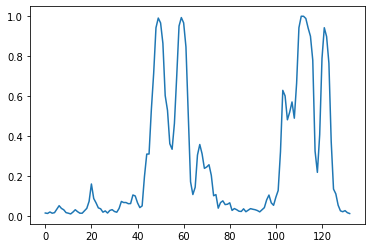

(133,)


In [3]:
# nn_detector_gen.set_stride(0.05)
# file = '2013-07-07UT14:48:18.20771914.marion.vr2'
# sample = Sample(dataset_loc, site, file)
# print(sample.get_time().shape)
# probs = nn_detector_gen.detection_probabilities(file)
# plt.plot(probs)
# plt.show()
# print(probs.shape)

In [4]:
# t = nn_detector_gen.detection_starting_locations(file,  probs=probs, thresh=0.5, concav=True, concav_window=0.05,concav_error=-0.01)
# print(t)
# print(sample.awda_whistlers(time_err=1)[0])

[['2.194' '0.989']
 ['2.642' '0.991']
 ['4.612' '0.628']
 ['4.970' '0.998']
 ['5.418' '0.940']]
[[ 2.4 31. ]
 [ 2.9 33. ]
 [ 5.2 78. ]
 [ 5.3 85. ]]
